## Solar Stations statistics

This page presents statistics on solar radiation monitoring stations using data from SolarStations.org.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime as dt
from IPython.display import Markdown as md
from matplotlib.lines import Line2D

In [2]:
path = 'https://solarstations.org/_downloads/f85f41dda48ab008055bbfad91e578b2/SolarStationsOrg-station-catalog.csv'
df = pd.read_csv(path)

In [3]:
dfs = df[['Station full name','Time period']]
dfs.index = dfs['Station full name']
dfs = dfs.drop(columns=['Station full name'])

# make different colors based on stations status
dfs['color'] = 'red'
dfs['color'] = dfs['color'].mask(dfs['Time period'].str.endswith('-'), 'green').mask(dfs['Time period'].str.endswith('?'), 'blue')

# Drop stations with unknown time period ('?' or '')
dfs = dfs.loc[~dfs['Time period'].isin(['?', '']), :]

# define start operation period
dfs['start'] = dfs['Time period'].str[:4].astype(int)

# Drop stations with only one year of data
dfs = dfs.loc[~(dfs['Time period'] == dfs['start'].astype(str)), :]

# define end operation period
dfs['end'] = dfs['Time period'].str[4:]
dfs['end'] = dfs['Time period'].str[5:].mask(dfs['Time period'].str.endswith('-'), dt.now().year).mask(dfs['Time period'].str.endswith('-?'), dt.now().year).mask(dfs['Time period'].str.endswith('-?'), dt.now().year)
dfs['end'] = dfs['end'].astype(int)

# sort the dataframe based on the start operation date and station status (color)
dfs = dfs.sort_values(['start','color'], ascending=False)

dfs = dfs.reset_index()

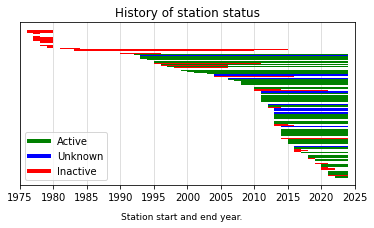

In [44]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(dfs.index, dfs['end']-dfs['start'], left=dfs['start'], color=dfs['color'], zorder=2)
ax.set_yticks([])
ax.set_title('History of station status')
ax.set_xticks(np.arange(1970,dt.today().year+5,5))
ax.set_xlim(1975,dt.today().year+1)
ax.grid(alpha=0.5, zorder=-1)
plt.figtext(0.5, -0.03, 'Station start and end year.', wrap=True, horizontalalignment='center', fontsize=9)
# custom legend
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Active', 'Unknown', 'Inactive']);

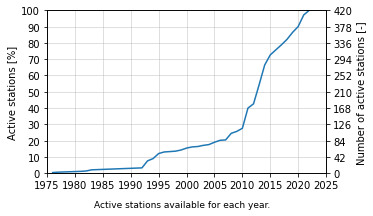

In [43]:
active_stations_count = dfs.loc[dfs['color']=='green', 'start'].value_counts().sort_index()

fig, axes = plt.subplots(figsize=(5, 3))
axes.plot(active_stations_count.cumsum().divide(active_stations_count.sum()).multiply(100))
axes.set_ylim(0, 100)

ax2 = axes.twinx()
ax2.set_ylim([0,active_stations_count.cumsum().max()])

# allign the ticks of the two y-axes
nticks = 11
axes.yaxis.set_major_locator(ticker.LinearLocator(nticks))
ax2.yaxis.set_major_locator(ticker.LinearLocator(nticks))

ax2.set_ylabel('Number of active stations [-]')
axes.set_ylabel('Active stations [%]')
axes.grid(alpha=0.5)
axes.set_xticks(np.arange(1970,dt.today().year+5,5))
axes.set_xlim(1975,dt.today().year+1)
plt.figtext(0.5, -0.03, 'Active stations available for each year.', wrap=True, horizontalalignment='center', fontsize=9);

In [45]:
a = dfs.loc[dfs['color']=='green']
year = 1993
stations_before_year = len(a.loc[a['start']<year])
percent_before_year = round(1-(len(a)-len(a.loc[a['start']<year]))/len(a),3)*100
total_active = len(a)

last_20_years = dt.today().year-20
stations_last_20_years = len(a.loc[a['start']>last_20_years])
percent_last_20_years = round(1-(len(a)-len(a.loc[a['start']>last_20_years]))/len(a),3)*100

df['Unknown_status'] = list(map(lambda x: str(x).endswith('?'), df['Time period']))
dfu = df.loc[df['Unknown_status']]

In [46]:
md(f'The following conclusions can be drawn from the figures above: \n'
   f'* Only {stations_before_year} stations out of {total_active} have been in operation before {year} (~{int(percent_before_year)}%) \n'
   f'* {stations_last_20_years} stations out of {total_active} have been in operation in the last 20 years (~{int(percent_last_20_years)}%) \n'
   f'* There are {len(dfu)} stations whose operation status is unknown, which demonstrates the huge barrier on accessing information and data from solar stations!')

The following conclusions can be drawn from the figures above: 
* Only 14 stations out of 420 have been in operation before 1993 (~3%) 
* 346 stations out of 420 have been in operation in the last 20 years (~82%) 
* There are 111 stations whose operation status is unknown, which demonstrates the huge barrier on accessing information and data from solar stations!

# Historical and active stations

Text(0.5, 0, '')

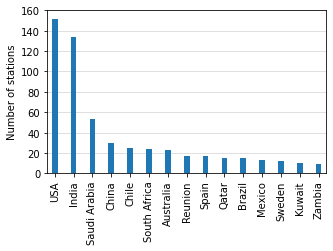

In [32]:
# Top 15 countries
countries = df.groupby('Country').count()['Station full name'].sort_values(ascending=False)[:15]
# Plot
fig, axes = plt.subplots(figsize=(5,3))
countries.plot.bar(zorder=2, width=0.3)
axes.set_ylabel('Number of stations')
axes.set_ylim(0, countries.iloc[0]+5)
axes.set_yticks(np.arange(0,countries.iloc[0]+20,20))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_xlabel('')
plt.show()

In [33]:
print('List of historical and active networks:')
df['Network'].str.replace(' ','').str.split(';', expand=True).stack().value_counts()

List of historical and active networks:


SRRA                                                    123
ESMAP                                                    89
BSRN                                                     79
WEST                                                     52
NOAA                                                     39
IOS-net                                                  26
SAURAN                                                   22
WMORRC                                                   17
BOM                                                      15
QEERI                                                    15
SONDA                                                    14
AEMET                                                    14
FONDEF                                                   13
WMOGAW                                                   12
SMHI                                                     12
enerMENA                                                 10
SURFRAD                                 

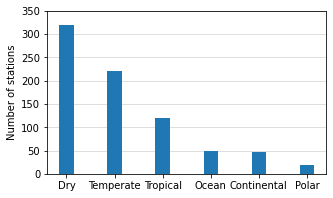

In [49]:
# Stations per KG climate zone
climate_zone = df.groupby('Koeppen Geiger climate zone').count()['Station full name'].sort_values(ascending=False)
# plot
fig, axes = plt.subplots(figsize=(5,3))
climate_zone.plot.bar(zorder=2, width=0.3, rot=0)
axes.set_ylim(0, climate_zone.iloc[0]+5)
axes.set_yticks(np.arange(0,climate_zone.iloc[0]+50,50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of stations')
axes.set_xlabel('')
plt.show()

# Only active stations

In [47]:
# create a column indicating if a station is active
df['Active'] = df['Time period'].str.endswith('-')
# create a new dataframe containing only the active stations

# REMOVE THE ==True WHEN THERE ARE NO NAN VALUES
dfa = df.loc[df['Active']==True]
print(f'The number of active stations: {len(dfa)}')

The number of active stations: 420


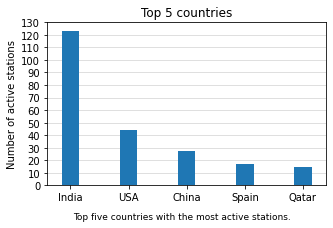

In [57]:
# Top 5 active station countries
countries_active = dfa.groupby('Country').count()['Station full name'].sort_values(ascending=False)[:5]
# plot
fig, axes = plt.subplots(figsize=(5,3))
countries_active.plot.bar(zorder=2, width=0.3, rot=0)
axes.set_yticks(np.arange(0, countries_active.iloc[0]+10, 10))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('')
axes.set_title('Top 5 countries')
plt.figtext(0.5, -0.03, 'Top five countries with the most active stations.', wrap=True, horizontalalignment='center', fontsize=9);

It should be noted that the figure above shows only the active stations for each country. However, for many countries, there might have been an active netowrk in the past or some measurement campaign. These data are also included in solarstations and can be used as historical data. If the historical data were also to be used, then the top five countries with the most stations would be:
* USA
* India
* Saudi Arabia
* China
* Chile

In [53]:
networks = dfa['Network'].str.replace(' ','').str.split(';', expand=True).stack().value_counts()

md(f"Most of the active stations belong to a network, which makes their data easier to access (as there is usually a website), and the stations are often better maintained. The 10 largest active networks are:\n"
   f'* {networks.index[0]} : {networks.iloc[0]} \n'
   f'* {networks.index[1]} : {networks.iloc[1]} \n'
   f'* {networks.index[2]} : {networks.iloc[2]} \n'
   f'* {networks.index[3]} : {networks.iloc[3]} \n'
   f'* {networks.index[4]} : {networks.iloc[4]} \n'
   f'* {networks.index[5]} : {networks.iloc[5]} \n'
   f'* {networks.index[6]} : {networks.iloc[6]} \n'
   f'* {networks.index[7]} : {networks.iloc[7]} \n'
   f'* {networks.index[8]} : {networks.iloc[8]} \n'
   f'* {networks.index[9]} : {networks.iloc[9]} \n'
   f'* {networks.index[10]} : {networks.iloc[10]} \n'
)

Most of the active stations belong to a network, which makes their data easier to access (as there is usually a website), and the stations are often better maintained. The 10 largest active networks are:
* SRRA : 123 
* ESMAP : 63 
* BSRN : 60 
* IOS-net : 15 
* QEERI : 15 
* AEMET : 14 
* enerMENA : 10 
* WMORRC : 10 
* WMOGAW : 8 
* SURFRAD : 7 
* SOLRAD : 7 


### Active stations per continent

In [56]:
continents = dfa.groupby('Continent').count().sort_values(by='Continent')['Station full name']
continents

Continent
Africa            59
Antarctica         6
Asia             209
Europe            55
North America     60
Oceania            9
South America     16
Name: Station full name, dtype: int64

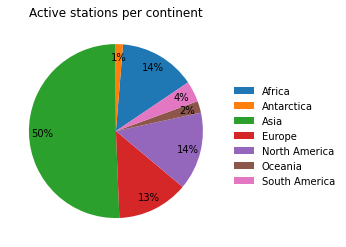

In [77]:
fig, axes = plt.subplots(figsize=(4,4))

pie = axes.pie(continents, autopct='%1.0f%%', pctdistance=0.85, startangle=34)
axes.legend(continents.index, loc=2, bbox_to_anchor=(1,0.75), frameon=False)
axes.set_title('Active stations per continent');

In [16]:
# land areas of contients per km^2 from Wikipedia
continent_area={
    'Asia':44614000,
    'Africa':30365000,
    'North America':24230000,
    'South America':17814000,
    'Antarctica':14200000,
    'Europe':10000000,
    'Oceania':8510926
   }

In [17]:
station_per_km = pd.Series(dtype='float64')

for i in continents.index:
    station_per_km[i] = continents[i]/continent_area[i]*1000000 # this is stations per Tm^2

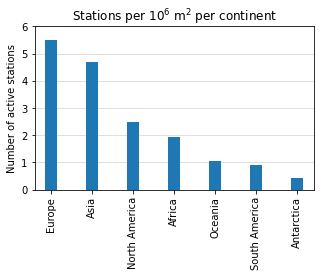

In [78]:
fig, axes = plt.subplots(figsize=(5,3))
station_per_km.sort_values(ascending=False).plot.bar(zorder=2, width=0.3, rot=90)
axes.set_yticks(np.arange(0,station_per_km.sort_values(ascending=False).iloc[0]+1,1))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('')
axes.set_title('Stations per 10$^6$ m$^2$ per continent');

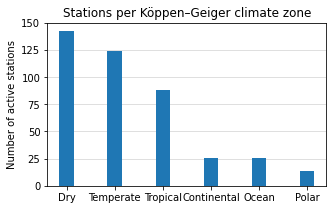

In [79]:
# Stations per KG climate zone
climate_zone = dfa.groupby('Koeppen Geiger climate zone').count()['Station full name'].sort_values(ascending=False)
# plot
fig, axes = plt.subplots(figsize=(5,3))
climate_zone.plot.bar(zorder=2, width=0.3, rot=0)
axes.set_ylim(0, climate_zone.iloc[0]+5)
axes.set_yticks(np.arange(0,climate_zone.iloc[0]+25,25))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_xlabel('')
axes.set_title('Stations per Köppen–Geiger climate zone');

### Active stations and altitude

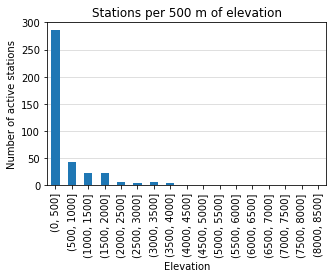

In [80]:
stations_per_500m = dfa.groupby(pd.cut(dfa['Elevation'], np.arange(0, 9000, 500)), observed=False)['Station full name'].count()

fig, axes = plt.subplots(figsize=(5, 3))
stations_per_500m.plot.bar(zorder=2)
axes.set_yticks(np.arange(0,stations_per_500m[1]+50,50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_title('Stations per 500 m of elevation');

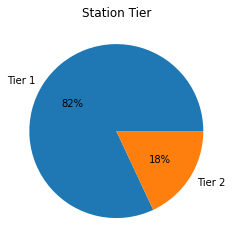

In [59]:
# Station tier
tier_rename = {1: 'Tier 1', 2: 'Tier 2'}

fig, axes = plt.subplots(figsize=(4,4))
dfa['Tier'].map(tier_rename).convert_dtypes().value_counts().\
    plot.pie(autopct='%1.0f%%')
axes.set_ylabel('')
axes.set_title('Station tier');

The figure above shows the percentage of active stations categorized as either Tier 1 or Tier 2. It can be observed that most of the active stations are Tier 1, which means that they measure global horizontal irradiance (GHI), diffuse horizontal irradiance (DHI) using a shadow ball, and direct normal irradiance (DNI) using a pyrheliometer mounted on a solar tracker. For more information on the station tier classifications, see [the station requirements page](station_requirements).

The number of stations measuring each irradiance component is presented in the figure below.

### Components

In [ ]:
component_dict = {
    'G': 'GHI',
    'D': 'DHI',
    'B': 'DNI',
}

components = dfa['Components'].str.split(';', expand=True).stack().value_counts()
components.reset_index().map(components_dict)

fig, axes = plt.subplots(figsize=(7, 5))
components.plot.bar(zorder=2)
axes.set_yticks(np.arange(0,components.iloc[0]+50,50))
axes.grid(alpha=0.5, which='both', axis='y', zorder=-1)
axes.set_ylabel('Number of active stations')
axes.set_title('Irradiance components measured');
components

In [72]:
dfa['Components'].str.split(';', expand=True).stack().value_counts()

G         366
D         357
B         352
IR         36
UV         29
PAR        14
RSI         8
GTI         2
Albedo      2
RSR         1
Name: count, dtype: int64

### Active stations that have data freely available

In [73]:
df_un = dfa[(dfa['Data availability'].isna()) | (dfa['Data availability']=='Not available')]
df_av = dfa[(dfa['Data availability']=='Freely') | (dfa['Data availability']=='Free')]
df_req = dfa[dfa['Data availability']=='Upon request']

In [75]:
md(f'Finding and downloading data from solar stations can be a tedious process. The main reason is that, most times, there is no information on how to obtain the data. '
   f'There are {len(df_av)} active stations where data can be freely donwloaded and {len(df_un)} stations for which there is no data access. The figure below gives the corresponding percentages.')

Finding and downloading data from solar stations can be a tedious process. The main reason is that, most times, there is no information on how to obtain the data. There are 207 active stations where data can be freely donwloaded and 179 stations for which there is no data access. The figure below gives the corresponding percentages.

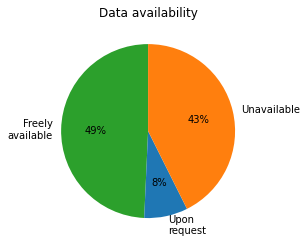

In [76]:
fig, axes = plt.subplots()

axes.pie([len(df_av), len(df_req), len(df_un)], labels=['Freely\navailable','Upon\nrequest','Unavailable'], 
         colors=['C2','C0','C1'], autopct='%1.0f%%', startangle=90)
axes.set_title('Data availability');